# VGG16 network using slim

In [1]:
#import sys
#sys.path.append("$HOME/models/research/slim/")

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

### Load a VGG16 graph

In [2]:
from nets import vgg

In [3]:
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])

In [4]:
with slim.arg_scope(vgg.vgg_arg_scope()):
  outputs, end_points = vgg.vgg_16(inputs, num_classes=None, is_training=False)

In [5]:
print(outputs)

Tensor("vgg_16/fc7/Relu:0", shape=(?, 1, 1, 4096), dtype=float32)


In [6]:
for node in end_points:
  print(node)

vgg_16/conv1/conv1_1
vgg_16/conv1/conv1_2
vgg_16/pool1
vgg_16/conv2/conv2_1
vgg_16/conv2/conv2_2
vgg_16/pool2
vgg_16/conv3/conv3_1
vgg_16/conv3/conv3_2
vgg_16/conv3/conv3_3
vgg_16/pool3
vgg_16/conv4/conv4_1
vgg_16/conv4/conv4_2
vgg_16/conv4/conv4_3
vgg_16/pool4
vgg_16/conv5/conv5_1
vgg_16/conv5/conv5_2
vgg_16/conv5/conv5_3
vgg_16/pool5
vgg_16/fc6
vgg_16/fc7


In [7]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("./graphs/01_vgg16", sess.graph)
  writer.close()

### Download the VGG16 checkpoint: 

```
$ CHECKPOINT_DIR='../checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
$ tar -xvf vgg_16_2016_08_28.tar.gz
$ mv vgg_16_2016_08_28.tar.gz ${CHECKPOINT_DIR}
$ rm vgg_16_2016_08_28.tar.gz
```

### Restore VGG16 weights using `tf.saver.restore`

#### Read a image

In [8]:
def vgg_preprocessing(image):
  """vgg image preprocessing
  output image is applied by mean_image_subtraction
  
  _R_MEAN = 123.68
  _G_MEAN = 116.78
  _B_MEAN = 103.94

  Args:
    image (PIL image): image with shape [height, width, channels]
    
  Returns:
    image (np.int32): np.array with shape [224, 224, 3] applied by mean_image_subtraction
  """
  image = image.resize((224, 224))
  image = np.asarray(image)
  image = image.astype(np.float32)
  image[:,:,0] -= 123.68 # for _R_MEAN
  image[:,:,1] -= 116.78 # for _G_MEAN
  image[:,:,2] -= 103.94 # for _B_MEAN
  
  return image

In [9]:
my_image = Image.open('../input_data/my_cat1.jpg')
my_image = vgg_preprocessing(my_image)
my_image = np.expand_dims(my_image, axis=0)

In [10]:
saver = tf.train.Saver()

with tf.Session(config=sess_config) as sess:

  # use saver object to load variables from the saved model
  saver.restore(sess, "../checkpoints/vgg_16.ckpt")
  
  # print conv1_1 weight itself
  conv1_1_w = sess.run(tf.trainable_variables()[0])
  
  # print feature maps
  conv1_1, conv2_1, \
  conv3_2, conv4_3, \
  conv5_3 = sess.run([end_points['vgg_16/conv1/conv1_1'],
                      end_points['vgg_16/conv2/conv2_1'],
                      end_points['vgg_16/conv3/conv3_2'],
                      end_points['vgg_16/conv4/conv4_3'],
                      end_points['vgg_16/conv5/conv5_3']],
                     feed_dict={inputs: my_image})

INFO:tensorflow:Restoring parameters from ../checkpoints/vgg_16.ckpt


### Print feature maps

In [12]:
def print_all_feature_maps(layer, layer_name):
  """Print all feature maps
    This code is borrowed from "Deep Learning with Python" (by Chollet)
  
  Args:
    layer (4-rank Tensor): feature maps
    layer_name (string): name of feature maps
    
  Returns:
    print all feature maps
  """
  num_features = layer.shape[-1]
  size = layer.shape[1]
  images_per_row = 16
  for feature_map in range(num_features):
    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))

    for col in range(num_cols):
      for row in range(images_per_row):
        channel_image = layer[0,:,:,col * images_per_row + row]

        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

#### Print feature maps of conv1_1

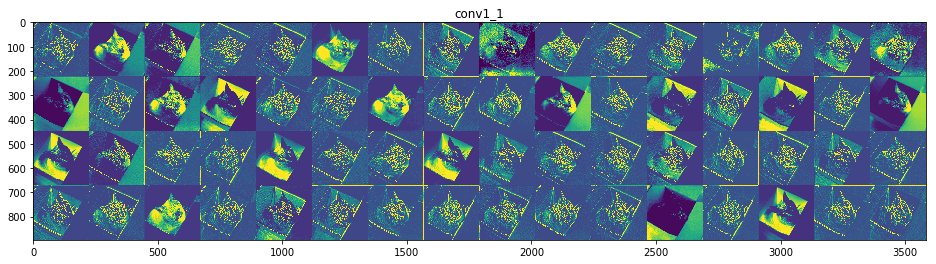

In [13]:
print_all_feature_maps(conv1_1, 'conv1_1')

#### Print feature maps of conv2_1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


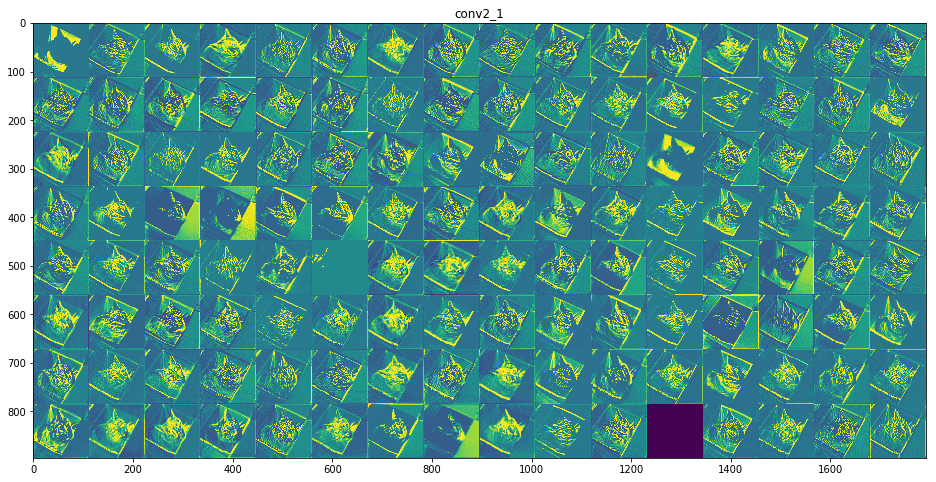

In [14]:
print_all_feature_maps(conv2_1, 'conv2_1')

#### Print feature maps of conv3_2

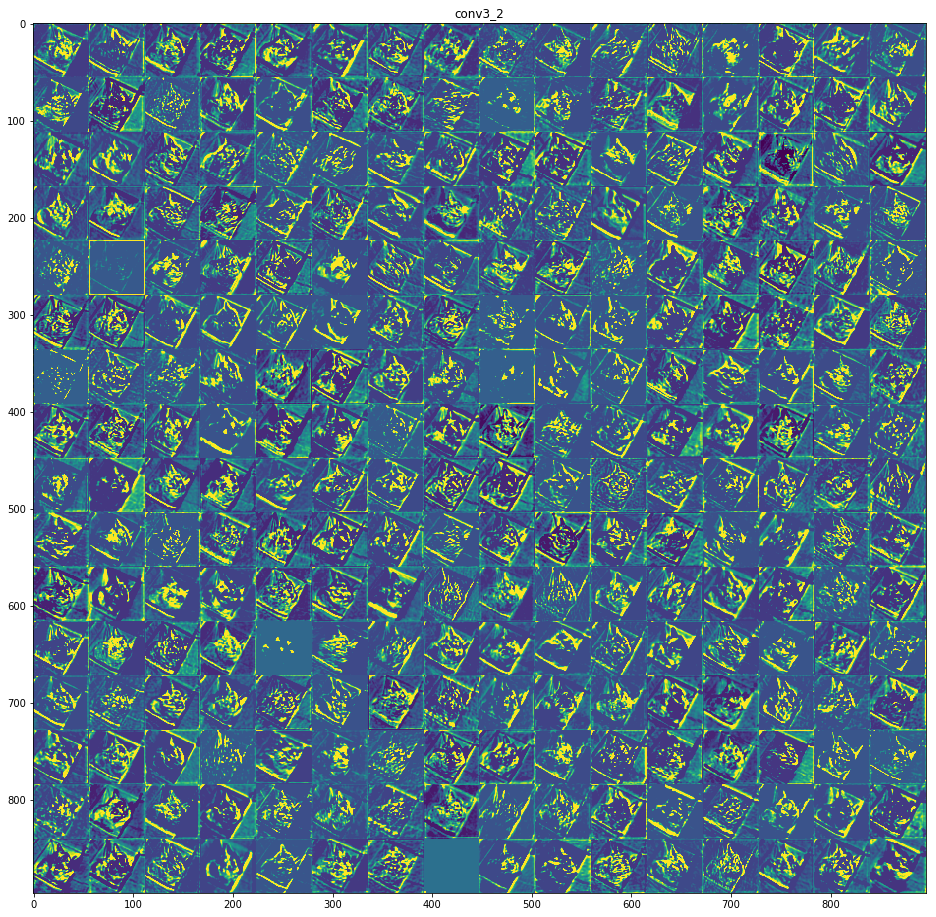

In [15]:
print_all_feature_maps(conv3_2, 'conv3_2')

#### Print feature maps of conv4_3

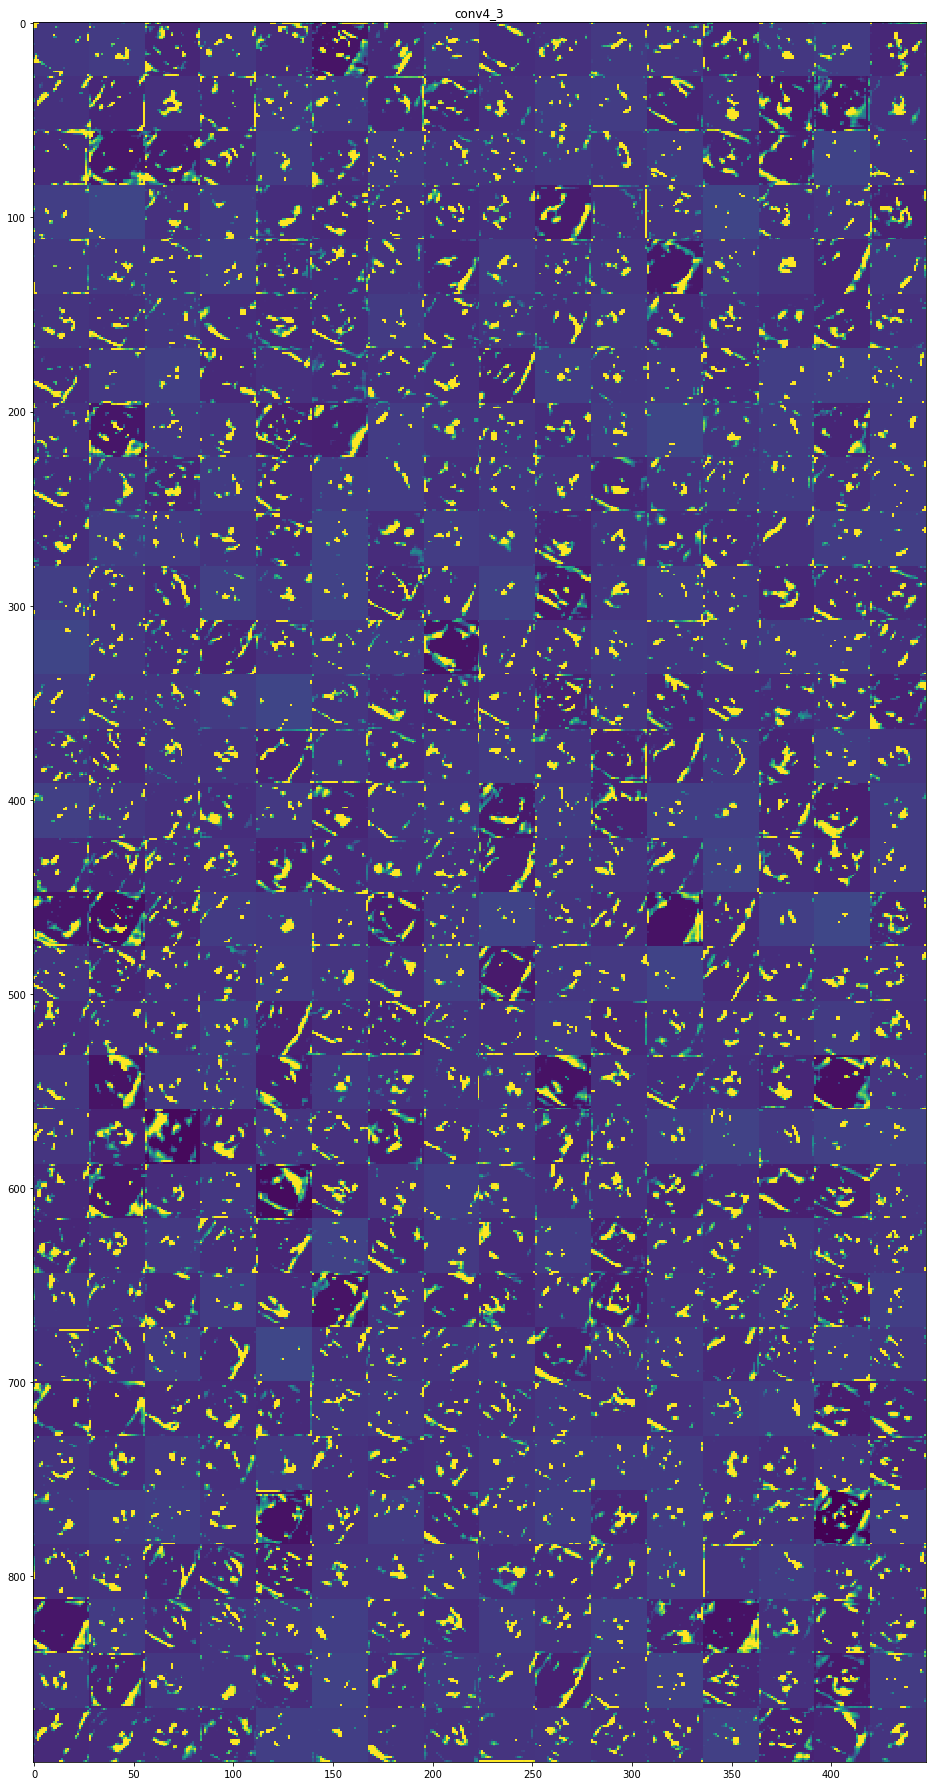

In [16]:
print_all_feature_maps(conv4_3, 'conv4_3')

#### Print feature maps of conv5_3

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


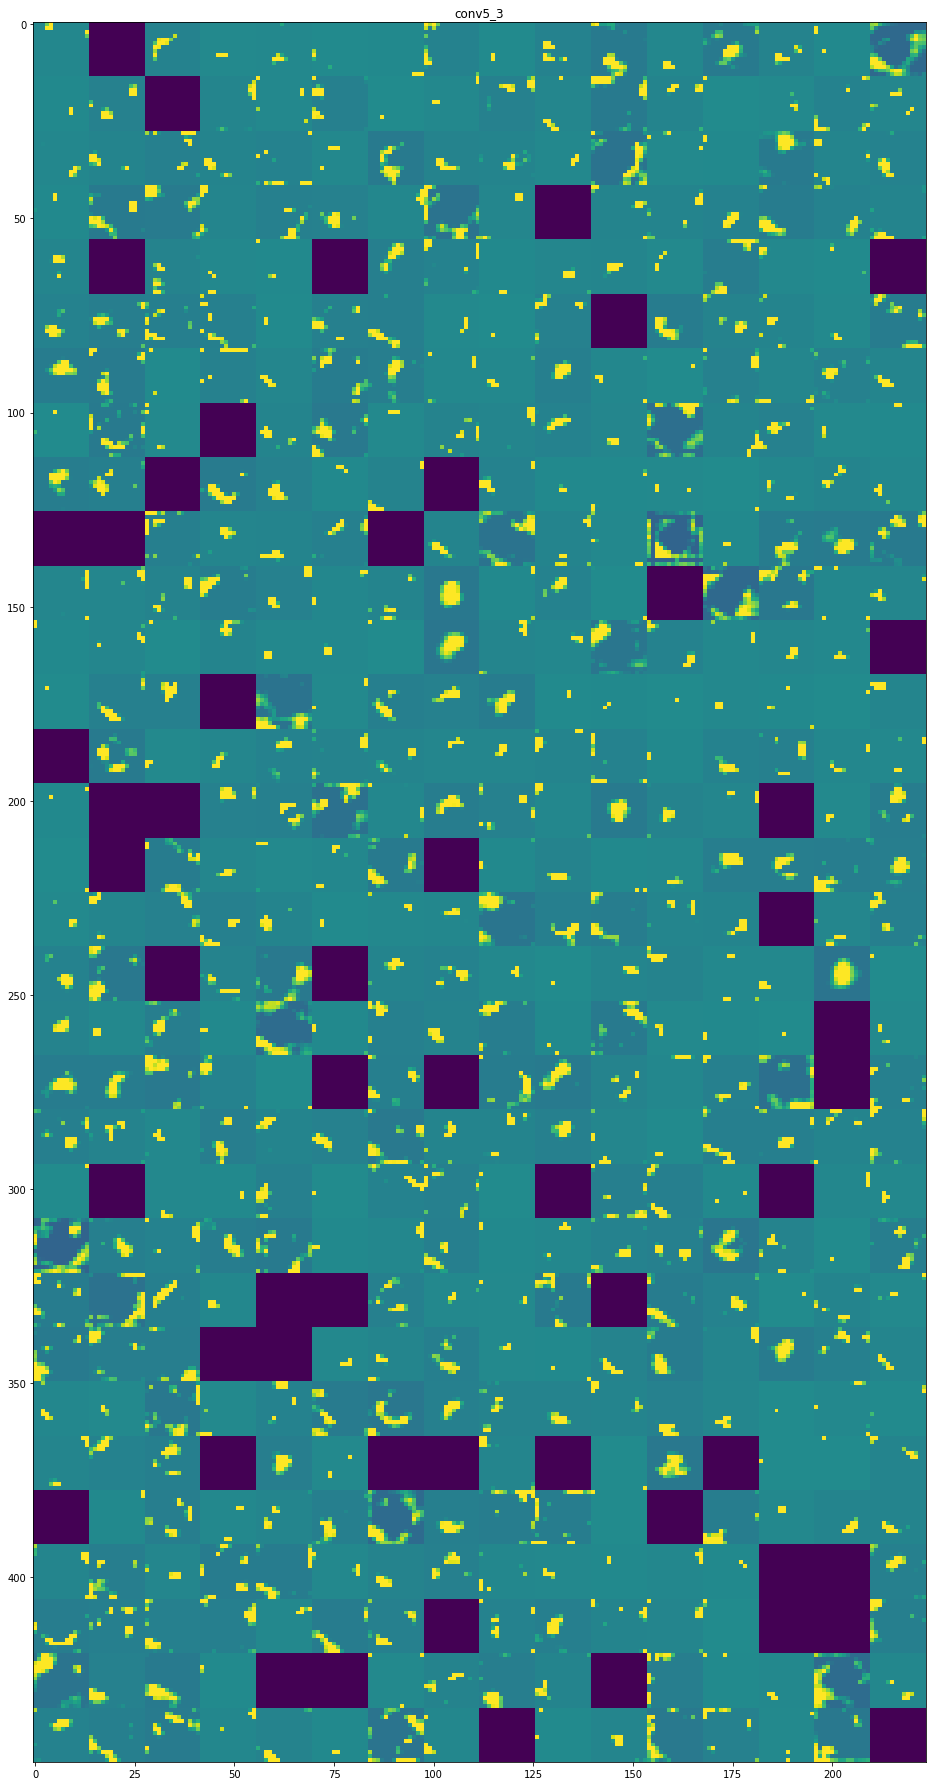

In [17]:
print_all_feature_maps(conv5_3, 'conv5_3')